In [130]:
import cv2
import numpy as np
import base64
from io import BytesIO
from PIL import Image
import os
import time

from fs.tree import render
from mss import mss
import pydirectinput
import pytesseract
from gymnasium import Env  # Изменено на gymnasium
from gymnasium.spaces import Box, Discrete
from selenium.webdriver.common.alert import Alert
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [131]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Capture game frames
        self.cap = mss()
        self.game_location = {'top': 400, 'left': 0, 'width': 1000, 'height': 500}
        self.done_location = {'top': 205, 'left': 630, 'width': 660, 'height': 70}
        
        
    def step(self, action):
        action_map = {
            0:'space',
            1: 'down', 
            2: 'no_op'
        }
        if action !=2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done() 
        observation = self.get_observation()
        reward = 1 
        info = {}
        return observation, reward, done, info
        
    
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation()
        
    def render(self):
        cv2.imshow('Game', self.current_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
         
    def close(self):
        cv2.destroyAllWindows()
    
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel
    
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))
        done_strings = ['GAME', 'GAHE']
        done=False
        # if np.sum(done_cap) < 44300000:
        #     done = True
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

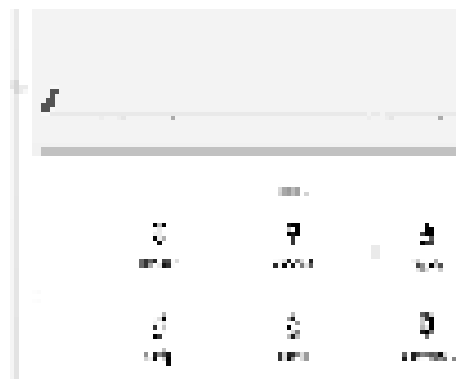

In [129]:
from matplotlib import pyplot as plt

env = WebGame()
obs = env.get_observation()

# Вывод изображения в оттенках серого
plt.imshow(obs[0], cmap='gray')
plt.axis('off')  # Убрать оси для чистого отображения
plt.show()


In [100]:
env = WebGame()

for episode in range(10):  # Запуск 10 игр
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done: 
        obs, reward, truncated, done, info = env.step(env.action_space.sample())
        total_reward += reward
        env.render()    
    print(f'Total reward for episode {episode} is {total_reward}')
    env.close()  

Total reward for episode 0 is 16
Total reward for episode 1 is 14
Total reward for episode 2 is 16
Total reward for episode 3 is 14
Total reward for episode 4 is 15
Total reward for episode 5 is 17
Total reward for episode 6 is 22
Total reward for episode 7 is 12
Total reward for episode 8 is 29
Total reward for episode 9 is 17


In [142]:
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import os

# Define a custom callback to save model checkpoints and track performance
class SaveOnBestTrainingRewardCallback(BaseCallback):
    def __init__(self, save_path, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.save_path = save_path
        self.best_mean_reward = -float('inf')

    def _on_step(self) -> bool:
        if self.n_calls % 1000 == 0:  # Save every 1000 steps
            reward = self.locals.get('reward', None)  # Get reward from locals
            if reward and reward > self.best_mean_reward:
                self.best_mean_reward = reward
                self.model.save(self.save_path)
                print(f"Saving new best model with reward: {self.best_mean_reward}")
        return True

# Create the environment
env = WebGame()  # Ensure WebGame is defined

# Ensure the tensorboard log directory exists
tensorboard_log_dir = "dqn_tensorboard/"
os.makedirs(tensorboard_log_dir, exist_ok=True)

# Initialize the model
model = DQN('CnnPolicy', env, verbose=1, buffer_size=100000, batch_size=32, learning_starts=1000, optimize_memory_usage=False, tensorboard_log=tensorboard_log_dir)

# Define the path to save the model
model_save_path = "best_model_dqn"

# Create the callback instance
callback = SaveOnBestTrainingRewardCallback(save_path=model_save_path)

# Train the model
model.learn(total_timesteps=10000, callback=callback)

# Save the trained model
model.save("final_model_dqn")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


MemoryError: Unable to allocate 792. MiB for an array with shape (100000, 1, 1, 83, 100) and data type uint8

In [7]:
env = WebGame()
env_checker.check_env(env)

In [144]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [145]:
CHECKPOINT_DIR = 'train/'
LOG_DIR = 'logs/'

In [146]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [32]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [33]:
env = WebGame()

In [52]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=100000, batch_size=32, learning_starts=1000, optimize_memory_usage=False)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [61]:
model.learn(total_timesteps=100000, callback=callback)

ImportError: Trying to log data to tensorboard but tensorboard is not installed.

In [53]:
model.load('train/best_model_88000')

D:\Users\Legion\anaconda3\envs\env_pt\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 4.90GB
  warnings.warn(


In [81]:
for episode in range(5): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [78]:
env.close()